In [1]:
import numpy as np
from sklearn.utils import check_X_y, check_array
from sklearn.utils.multiclass import _check_partial_fit_first_call
from sklearn.utils.fixes import in1d
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

def update_mean(n_past, mu, var, X):
    if X.shape[0] == 0:
        return mu, var

    n_new = X.shape[0]
    new_var = np.var(X, axis=0)
    new_mu = np.mean(X, axis=0)

    if n_past == 0:
        return new_mu, new_var

    n_total = float(n_past + n_new)

    total_mu = (n_new * new_mu + n_past * mu) / n_total

    old_ssd = n_past * var
    new_ssd = n_new * new_var
    total_ssd = (old_ssd + new_ssd +
                 (n_past / float(n_new * n_total)) *
                 (n_new * mu - n_new * new_mu) ** 2)
    total_var = total_ssd / n_total

    return total_mu, total_var

class GaussianNB:
        
    def roc_curve_(self, X, y_true):
        joint_log_likelihood = []
        for i in range(np.size(self.classes_)):
            jointi = np.log(self.class_prior_[i])
            n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
            n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
                                 (self.sigma_[i, :]), 1)
            joint_log_likelihood.append(jointi + n_ij)

        joint_log_likelihood = np.array(joint_log_likelihood).T

        fpr, tpr, _ = roc_curve(y_true=y_true, y_score=(joint_log_likelihood[:, 1] 
                                                        - joint_log_likelihood[:, 0]))
        plt.plot(fpr, tpr)
        plt.show()
        
        
    def predict(self, X):
        joint_log_likelihood = []
        for i in range(np.size(self.classes_)):
            jointi = np.log(self.class_prior_[i])
            n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
            n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) /
                                 (self.sigma_[i, :]), 1)
            joint_log_likelihood.append(jointi + n_ij)

        joint_log_likelihood = np.array(joint_log_likelihood).T
        return self.classes_[np.argmax(joint_log_likelihood, axis=1)]

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        X, y = check_X_y(X, y)

        epsilon = 1e-9 * np.var(X, axis=0).max()
        
        n_features = X.shape[1]
        n_classes = len(self.classes_)
        self.theta_ = np.zeros((n_classes, n_features))
        self.sigma_ = np.zeros((n_classes, n_features))

        self.class_count_ = np.zeros(n_classes, dtype=np.float64)
        n_classes = len(self.classes_)
        self.class_prior_ = np.zeros(len(self.classes_), dtype=np.float64)
        classes = self.classes_

        unique_y = np.unique(y)
        unique_y_in_classes = in1d(unique_y, classes)

        for y_i in unique_y:
            i = classes.searchsorted(y_i)
            X_i = X[y == y_i, :]

            N_i = X_i.shape[0]

            new_theta, new_sigma = update_mean(
                self.class_count_[i], self.theta_[i, :], self.sigma_[i, :],
                X_i)

            self.theta_[i, :] = new_theta
            self.sigma_[i, :] = new_sigma
            self.class_count_[i] += N_i

        self.sigma_[:, :] += epsilon
        self.class_prior_ = self.class_count_ / self.class_count_.sum()

        return self

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
dataset = pd.read_csv('spambase.csv')

In [3]:
X = dataset.values[:, :-1]
y = dataset.label

In [4]:
clf = GaussianNB()
clf.fit(X, y)

# GaussianNB

In [5]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true=y, y_pred=clf.predict(X))

0.82286459465333628

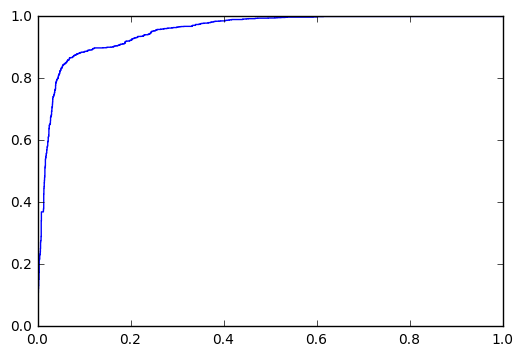

In [6]:
roc = clf.roc_curve_(X, y)

In [7]:
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import label_binarize
from sklearn.utils import check_X_y
from sklearn.utils.extmath import safe_sparse_dot

class MultinomialNB:

    
    def roc_curve_(self, X, y_true):
        jll = (safe_sparse_dot(X, self.feature_log_prob_.T) +
                self.class_log_prior_)
        fpr, tpr, _ = roc_curve(y_true=y_true, y_score=(jll[:, 1] - jll[:, 0]))
        plt.plot(fpr, tpr)
        plt.show()
        
    def fit(self, X, y):
        X, y = check_X_y(X, y, 'csr')
        n_features = X.shape[1]

        labelbin = LabelBinarizer()
        Y = labelbin.fit_transform(y)
        self.classes_ = labelbin.classes_
        if Y.shape[1] == 1:
            Y = np.concatenate((1 - Y, Y), axis=1)

        n_effective_classes = Y.shape[1]
        self.class_count_ = np.zeros(n_effective_classes, dtype=np.float64)
        self.feature_count_ = np.zeros((n_effective_classes, n_features),
                                       dtype=np.float64)
        
        self.feature_count_ += safe_sparse_dot(Y.T, X)
        self.class_count_ += Y.sum(axis=0)
        smoothed_fc = self.feature_count_ + 1.0
        smoothed_cc = smoothed_fc.sum(axis=1)
        self.feature_log_prob_ = (np.log(smoothed_fc) -
                                  np.log(smoothed_cc.reshape(-1, 1)))
        
        n_classes = len(self.classes_)
        self.class_log_prior_ = (np.log(self.class_count_) -
                                     np.log(self.class_count_.sum()))
        return self
    
    def predict(self, X):
        jll = (safe_sparse_dot(X, self.feature_log_prob_.T) +
                self.class_log_prior_)
        return self.classes_[np.argmax(jll, axis=1)]



In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
dataset = pd.read_csv('smsspam.csv')


In [9]:
from sklearn.feature_extraction.text import CountVectorizer
def preprocessing(X, y):
    count_vect = CountVectorizer()
    temp = [line for line in X[:, 0]]
    x_res = count_vect.fit_transform(temp)
    sample = y.shape[0]
    y_res = np.empty(dtype=int, shape=(sample, ))
    for i in range(sample):
        if (y[i] == 'ham'):
            y_res[i] = 0
        else:
            y_res[i] = 1
    return x_res, y_res

In [10]:
X = dataset.values[:, 1:]
y = dataset.label
X, y = preprocessing(X, y)

In [11]:
clf = MultinomialNB()
clf.fit(X, y)

# MultinomialNB

In [12]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true=y, y_pred=clf.predict(X))

0.99353912419239054

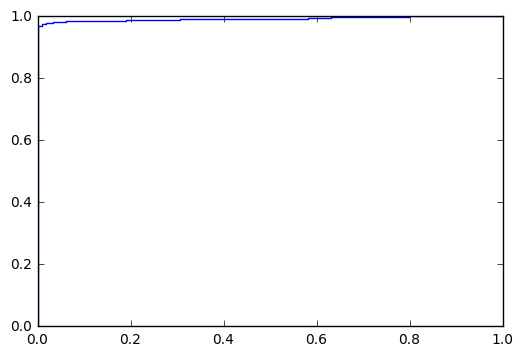

In [13]:
clf.roc_curve_(X, y)

In [14]:
class BernoulliNB:
    
    def roc_curve_(self, X, y_true):        
        n_classes, n_features = self.feature_log_prob_.shape
        n_samples, n_features_X = X.shape

        neg_prob = np.log(1 - np.exp(self.feature_log_prob_))
        jll = safe_sparse_dot(X, (self.feature_log_prob_ - neg_prob).T)
        jll += self.class_log_prior_ + neg_prob.sum(axis=1)
        
        fpr, tpr, _ = roc_curve(y_true=y_true, y_score=(jll[:, 1] - jll[:, 0]))
        plt.plot(fpr, tpr)
        plt.show()
        
        
    def fit(self, X, y):
        X, y = check_X_y(X, y, 'csr')
        n_features = X.shape[1]

        labelbin = LabelBinarizer()
        Y = labelbin.fit_transform(y)
        self.classes_ = labelbin.classes_
        if Y.shape[1] == 1:
            Y = np.concatenate((1 - Y, Y), axis=1)

        n_effective_classes = Y.shape[1]
        self.class_count_ = np.zeros(n_effective_classes, dtype=np.float64)
        self.feature_count_ = np.zeros((n_effective_classes, n_features),
                                       dtype=np.float64)
        
        self.feature_count_ += safe_sparse_dot(Y.T, X)
        self.class_count_ += Y.sum(axis=0)
        
        smoothed_fc = self.feature_count_ + 1.0
        smoothed_cc = self.class_count_ + 2.0

        self.feature_log_prob_ = (np.log(smoothed_fc) -
                                  np.log(smoothed_cc.reshape(-1, 1)))
        
        n_classes = len(self.classes_)
        self.class_log_prior_ = (np.log(self.class_count_) -
                                 np.log(self.class_count_.sum()))
        return self
    
    def predict(self, X):        
        n_classes, n_features = self.feature_log_prob_.shape
        n_samples, n_features_X = X.shape

        neg_prob = np.log(1 - np.exp(self.feature_log_prob_))
        jll = safe_sparse_dot(X, (self.feature_log_prob_ - neg_prob).T)
        jll += self.class_log_prior_ + neg_prob.sum(axis=1)

        return self.classes_[np.argmax(jll, axis=1)]

In [15]:
def binarize(value):
    X = np.empty(dtype=int, shape=value.shape)
    for i in range(value.shape[0]):
        for j in range(value.shape[1]):
            if (value[i, j] > 0):
                X[i, j] = 1
            else:
                X[i, j] = 0
    return X

In [16]:
import pandas as pd
import numpy as np
dataset = pd.read_csv('spambase.csv')
y = dataset.label
value = dataset.values[:, :-1]
X = binarize(value)

In [17]:
clf = BernoulliNB()
clf.fit(X, y)

# BernoulliNB

In [18]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true=y, y_pred=clf.predict(X))

0.88589437078895894

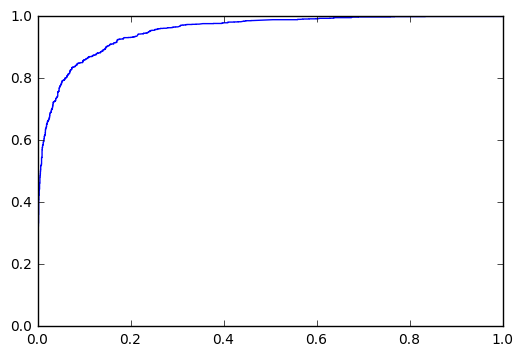

In [19]:
clf.roc_curve_(X, y)